<a href="https://colab.research.google.com/github/aswinkannanctr/landslide_Guardian/blob/main/Prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Real time moisture reading fetching

In [ ]:
!pip install requests numpy scikit-learn


Fetching Iot Reading(Real Time Moisture Reading)

In [ ]:
import requests
import numpy as np

def get_soil_moiture():
    # Function to fetch data from ThingSpeak
    def fetch_thingspeak_data(channel_id, read_key, results=1):
        url = f'https://api.thingspeak.com/channels/{channel_id}/feeds.json?api_key={read_key}&results={results}'
        response = requests.get(url)
        data = response.json()
        return data['feeds']

    # Preprocess data
    def preprocess_data(feeds, field):
        try:
            soil_moisture = float(feeds[0][f'field{field}'])
        except (KeyError, IndexError):
            print(f"Warning: 'field{field}' is missing in feed: {feeds}")
            soil_moisture = None
        return soil_moisture
    channel_id = "2509827"
    read_key = "ESOQ662OYSDMM2L3"
    field = 1

    # Fetch new real-time data for prediction
    new_feeds = fetch_thingspeak_data(channel_id, read_key)
    new_soil_moisture = preprocess_data(new_feeds, field)

    # Check if new data was correctly fetched and preprocessed
    if new_soil_moisture is None:
        raise ValueError("No valid new data fetched or all new data entries are missing required fields.")

    return new_soil_moisture

# Example usage:
soil_moisture_value = get_soil_moiture()
print("Soil Moisture Value:", soil_moisture_value)


Soil Moisture Value: 660.0


Real Time River Distance

In [ ]:
!pip install geopy
from geopy.distance import geodesic

# Coordinates of the location (Palakkad)
location_coords = (10.7734, 76.6548)  # Latitude, Longitude

# Coordinates of the river (example coordinates, replace with actual river coordinates)
river_coords = (10.8505, 76.2711)  # Latitude, Longitude

# Calculate the distance
distance = geodesic(location_coords, river_coords).kilometers
print(f"Distance to the river: {distance:.2f} km")


Distance to the river: 42.82 km


Real-time Weather data Fetching

In [ ]:
import requests
from datetime import datetime

def get_weather_data():
    api_key = "b41ec3be35c7dac8aabbc21ba253137a"
    location = "Sreekrishnapuram"
    url = f"https://api.openweathermap.org/data/2.5/weather?q={location}&appid={api_key}&units=metric"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        try:
            # Extracting relevant information from the response
            rainfall = data.get('rain', {}).get('1h', 0)  # Rainfall in the last hour (default to 0 if not present)
            main = data.get('main', {})
            elevation = main.get('sea_level', 'N/A')  # Elevation angle (sea level pressure if available)
            date_time = data.get('dt', 'N/A')  # Date and time of the weather data (timestamp)

            # Convert timestamp to readable date-time if available
            if date_time != 'N/A':
                date_time = datetime.utcfromtimestamp(date_time).strftime('%Y-%m-%d %H:%M:%S')
            if elevation != 'N/A':
                # Calculate altitude in meters based on sea level pressure using ISA model approximation
                # Constants for ISA model
                T0 = 288.15  # Standard temperature at sea level in Kelvin
                L = 0.0065  # Temperature lapse rate in Kelvin per meter
                P0 = 1013.25  # Standard atmospheric pressure at sea level in hPa
                R = 287.05  # Universal gas constant for dry air in J/(kg·K)
                g = 9.80665  # Acceleration due to gravity in m/s^2

                altitude = (T0 / L) * (1 - (elevation / P0)**(L * R / g))

        except KeyError as e:
            print("Error extracting data from the response:", e)
            # Assign default values in case of any errors
            rainfall = 0
            date_time = 'N/A'
            altitude = 'N/A'
    else:
        print(f"Error: {response.status_code}, {response.text}")
        # Assign default values in case of error
        rainfall = 0
        date_time = 'N/A'
        altitude = 'N/A'

    return rainfall, altitude

# Retrieve data from the function
rainfall, altitude = get_weather_data()

# Print the results outside the function scope
print(f"Rainfall: {rainfall} mm")
#print(f"Date and Time: {date_time}")
print(f"Elevation (Estimated): {altitude:.2f} m")


Rainfall: 5.33 mm
Elevation (Estimated): 27.09 m


Linear Regression Model

Train accuracy: 64.94 %
Test accuracy: 66.53 %
Mean Squared Error: 0.69 %
R-squared Score: 0.67 %


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Predicted Landslide Severity: [2.14]


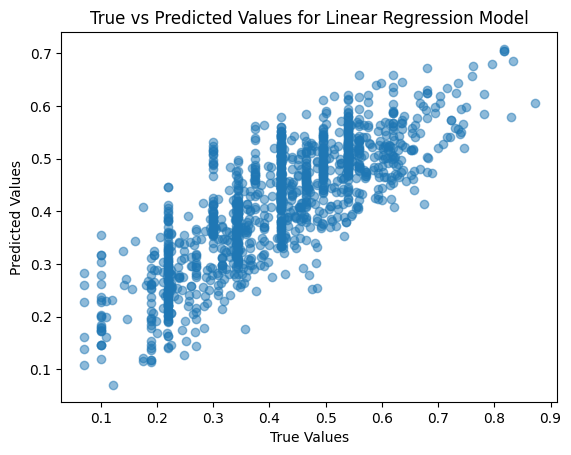

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import Ridge

data = pd.read_csv("modified_landslide_data.csv")

# Define your feature matrix (X) and target vector (y)
X = data[['Elevation', 'AAP(mm)', 'RiverDIST(m)','Slop(Degrees)','Soil Moisture']]
y = data['Landslide Risk']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

#L2 regularization
r_reg=linear_model.Ridge(alpha=20,max_iter=100,tol=0.1)
r_reg.fit(X_train, Y_train)
i=r_reg.score(X_train, Y_train)
j=r_reg.score(X_test, Y_test)
print("Train accuracy:",np.round(i*100,decimals=2),"%")
print("Test accuracy:",np.round(j*100,decimals=2),"%")

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print("Mean Squared Error:", np.round(mse*100,decimals=2),"%")
print("R-squared Score:", np.round(r2,decimals=2),"%")

soilMoisture =get_soil_moiture()
rainfall = get_weather_data()[0]
elevation = get_weather_data()[1]

# Generate a random slope value
min_slope = 10
max_slope = 40
random_slope = np.random.uniform(min_slope + 5, max_slope - 5)
#print("Random Slope Value:", random_slope)

new_data_point = [[elevation ,rainfall,0,random_slope,soilMoisture]]
new_data_point = np.array(new_data_point)

# Use the trained model to make predictions
predicted_severity = model.predict(new_data_point)

print("Predicted Landslide Severity:", np.round(predicted_severity,decimals=2))

# Plotting the true values against the predicted values
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for Linear Regression Model')
plt.show()


In [ ]:
import pandas as pd
# Check the maximum value of a column
df = pd.read_csv("modified_landslide_data.csv")
max_value = df['Slop(Degrees)'].max()

# Check the minimum value of a column
min_value = df['Slop(Degrees)'].min()

print(f"Maximum value of 'LR': {max_value}")
print(f"Minimum value of 'LR': {min_value}")
# Calculate the mean of the specified column
mean_value = df['RiverDIST(m)'].mean()
mean_value1 = df['Slop(Degrees)'].mean()

# Print the mean value
print(f"The mean of the column 'column_name' is: {mean_value,mean_value1}")


Warning System

In [ ]:
risk_value = predicted_severity
def get_warning_level(risk_value):
    if risk_value < 0.25:
        return "Low Risk"
    elif risk_value < 0.5:
        return "Moderate Risk"
    elif risk_value < 0.75:
        return "High Risk"
    else:
        return "Very High Risk"

warning_level = get_warning_level(risk_value)
print("Warning Level:", warning_level)

#Implementing Monitoring System
def check_risk_and_warning(model, new_data_point):
    predictions = model.predict(new_data_point)
    warnings = []
    for prediction in predictions:
        warning_level = get_warning_level(prediction)
        warnings.append(warning_level)
    return warnings
print(check_risk_and_warning(model,new_data_point))

Warning Level: Moderate Risk
['Moderate Risk']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Ddeployment of ML model into Webserver

In [ ]:
!pip install flask -ngrok


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -n


In [ ]:
import joblib

# `model` is the trained linear regression model
joblib.dump(model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

In [ ]:
from google.colab import files
files.download('linear_regression_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from flask import Flask, request, jsonify, send_from_directory
import pickle
from google.colab import files

# Initialize the Flask app
app = Flask(__name__, static_folder='static', static_url_path='')

# Function to handle model loading
def load_model():
    # Load the model
    uploaded = files.upload()
    model_file = next(iter(uploaded))
    model = pickle.load(open(model_file, 'rb'))
    return model

# Load the model
model = load_model('linear_regression_model.pkl')

@app.route('/')
def home():
    return send_from_directory(app.static_folder, 'index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # Get the data from the POST request
    data = request.get_json(force=True)
    # Convert data to numpy array
    prediction_data = np.array([data['features']])
    # Make prediction using the model
    prediction = model.predict(prediction_data)
    # Return the prediction as a JSON response
    return jsonify({'prediction': prediction[0]})

# Run the Flask app
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)





Manipulations in dataset

In [ ]:
import pandas as pd
import numpy as np

def calculate_soil_moisture(aap):
   # Define soil moisture based on AAP using a piecewise function or a nonlinear relationship
    if aap < 200:
        soil_moisture = aap * 0.5  # Example: Low AAP results in lower soil moisture
    elif aap < 400:
        soil_moisture = aap * 0.6  # Example: Moderate AAP results in moderate soil moisture
    elif aap < 600:
        soil_moisture = aap * 0.7  # Example: Higher AAP results in higher soil moisture
    elif aap < 900:
        soil_moisture = aap * 0.8  # Example: Higher AAP results in higher soil moisture
    else:
        soil_moisture = aap * 0.9  # Example: Very high AAP results in high soil moisture

    # Ensure soil moisture is within 0 to 100
    soil_moisture = np.clip(soil_moisture, 0, 100)
    return soil_moisture

def calculate_landslide_risk(row):
    weight_elevation = 0.25  # Adjust weight based on relative importance
    weight_slope = 0.2
    weight_river_distance = 0.15
    weight_fault_distance = 0.15
    weight_aap = 0.15  # Weight for AAP(mm)
    weight_soil_moisture = 0.1  # Weight for Soil Moisture

    elevation = row['Elevation']
    slope_degrees = row['Slop(Degrees)']
    river_distance = row['RiverDIST(m)']
    fault_distance = row['FaultDIST(m)']
    aap = row['AAP(mm)']
    soil_moisture = row['Soil Moisture']

    risk_score = 0

    # Risk factors based on feature values (adjust thresholds and weights as needed)
    if elevation > 1500:
        risk_score += weight_elevation * 0.8  # Higher weight for high elevation
    elif elevation > 1000:
        risk_score += weight_elevation * 0.5

    if slope_degrees > 25:
        risk_score += weight_slope * 1  # Maximum weight for steep slopes
    elif slope_degrees > 20:
        risk_score += weight_slope * 0.7

    if river_distance < 1000:
        risk_score += weight_river_distance * 0.8  # Higher weight for closer rivers
    elif river_distance < 500:
        risk_score += weight_river_distance * 1

    if fault_distance < 2000:
        risk_score += weight_fault_distance * (1 - fault_distance / 2000)  # Higher risk closer to faults

    if aap > 250:
        risk_score += weight_aap * 0.8  # Higher weight for higher AAP(mm)
    elif aap > 200:
        risk_score += weight_aap * 0.5

    if soil_moisture > 70:  # Example threshold for soil moisture in percentage
        risk_score += weight_soil_moisture * 1  # Higher risk for very wet soil
    elif soil_moisture > 50:
        risk_score += weight_soil_moisture * 0.7

    # Normalize risk score to 0-1 range
    risk_score = min(risk_score, 1)  # Ensure score doesn't exceed 1

    return risk_score

def add_soil_moisture_and_landslide_risk_column(new_dataset_final):
    # Read the CSV data
    data = pd.read_csv('new_dataset_final.csv')

    # Calculate soil moisture based on AAP
    data['Soil Moisture'] = data['AAP(mm)'].apply(calculate_soil_moisture)

    # Add a new column for landslide risk
    data['Landslide Risk'] = data.apply(calculate_landslide_risk, axis=1)

    return data

# Example usage
data_with_risk = add_soil_moisture_and_landslide_risk_column("new_dataset_final.csv")

# Save the DataFrame with landslide risk to a new CSV file
data_with_risk.to_csv('modified_landslide_data.csv', index=False)

print("Soil Moisture and Landslide Risk columns added successfully. The modified dataset is saved as 'modified_landslide_data.csv'.")


Soil Moisture and Landslide Risk columns added successfully. The modified dataset is saved as 'modified_landslide_data.csv'.
